In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Text Processing
import re
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from xgboost import XGBClassifier

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("mbti_1.csv")
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [3]:
lemmatiser = WordNetLemmatizer()

useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

In [4]:
# Splitting the MBTI personality into 4 letters and binarizing it
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [5]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [6]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [9]:
cntizer = CountVectorizer(analyzer="word", 
                          max_features=1000,  
                          max_df=0.7,
                          min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

# The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage:
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


In [10]:
# Posts in tf-idf representation
X = X_tfidf

In [11]:
my_posts  = """I believe that continuous learning and growth are essential for both personal fulfillment and professional success. I'm always seeking out new opportunities to expand my skills and knowledge, whether through formal training programs, mentorship relationships, or self-directed learning initiatives. Additionally, I place a strong emphasis on reflection and feedback, regularly assessing my strengths and areas for improvement. By embracing a growth mindset and remaining open to new challenges and experiences, I'm committed to continuously evolving and reaching my full potential.Thank you for having me. My name is AnNing, and I'm thrilled to be here today. I'm a people-oriented individual with a passion for making a positive impact in both professional and personal environments. I thrive on collaboration, communication, and building strong relationships with others.Absolutely. One instance that comes to mind is when I was leading a team to organize a large-scale charity event for our community. The project involved coordinating various volunteers, managing logistics, and ensuring that everything ran smoothly on the day of the event. There were numerous challenges along the way, such as unexpected changes in weather and last-minute adjustments to the program. However, I was able to keep the team motivated and focused by emphasizing the importance of our cause and the impact we could make together. By fostering open communication and providing support where needed, we were able to overcome obstacles and deliver a successful event that raised significant funds for charity.I believe in creating a supportive and inclusive environment where every team member feels valued and empowered to contribute their unique skills and perspectives. As an ENFJ, I naturally enjoy connecting with others and understanding their motivations and strengths. I strive to foster open communication channels, encourage brainstorming sessions, and actively listen to different viewpoints. By recognizing and celebrating the diversity within the team, we can harness our collective creativity and drive towards achieving our goals.Of course. There was a time when our company underwent a major restructuring, which resulted in significant changes to our team's responsibilities and reporting structure. Initially, it was a challenging transition for everyone, as it required us to quickly adapt to new roles and ways of working. However, I saw it as an opportunity to embrace change and rally the team together to navigate through the uncertainty. I organized regular check-in meetings to address any concerns and provided additional training and support where needed. By maintaining a positive attitude and focusing on the bigger picture, we were able to emerge stronger and more resilient as a team."""
mydata = pd.DataFrame(data={'type': ['ENFJ'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [12]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [13]:
print("The result is: ", translate_back(result)) 

The result is:  INFJ


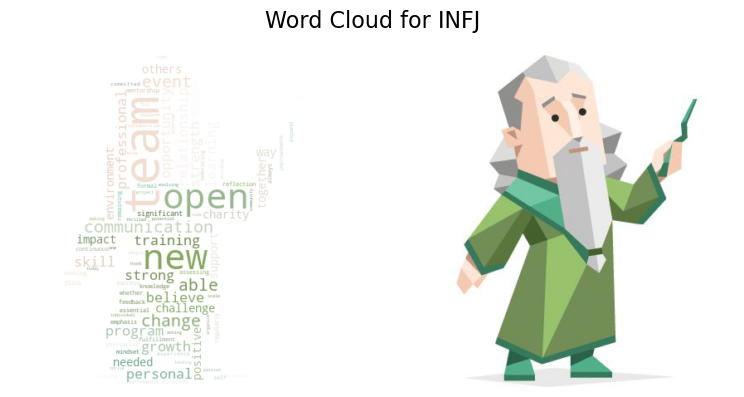

In [17]:
def generate_wordcloud(data, image_path, title):
    mask = np.array(Image.open(image_path))

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color="white", max_words=2000, mask=mask, stopwords=stopwords)
    wordcloud.generate(data)

    image_colors = ImageColorGenerator(mask)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
    plt.axis("off")
    plt.suptitle(f"Word Cloud for {title}", fontsize=16)
    plt.tight_layout()

    # Save the image
    plt.savefig("wordcloud.png")

    plt.show()

# Assuming you have defined the function translate_back(result) somewhere
personality_types = translate_back(result)

# Assuming my_posts is a string containing all your posts
data_file = " ".join(my_posts)

image_path = f'{personality_types.lower()}.jpg'
generate_wordcloud(data_file, image_path, personality_types)